### Installing Whisper and necessary packages 

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [1]:
! pip install git+https://github.com/openai/whisper.git
! pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-hr2diytd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-hr2diytd
  Resolved https://github.com/openai/whisper.git to commit b5851c6c40e753606765ac45b85b298e3ae9e00d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230314-py3-none-any.whl size=796955 sha256=2b0f1e1463b92b1df193d85e467ce6f9077419723cefe49fee7eaa02897eb555
  Stored in directory: /tmp/pip-ephem-wheel-cache-lmje7nx3/wheels/fe/03/29/e7919208d11b4ab32972cb448bb84a9a675d92cd52c9a48341
Successfully built openai-whisper
Looking in indexes: https://pypi.org/simple, https://us-p

In [2]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
!pip install -q gradio
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.1 MB/s eta 0:

In [4]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# import locale
# print(locale.getpreferredencoding())

### Running inference interactively

There are five model sizes, four with English-only versions, offering speed and accuracy tradeoffs. Below are the names of the available models and their approximate memory requirements and relative speed.


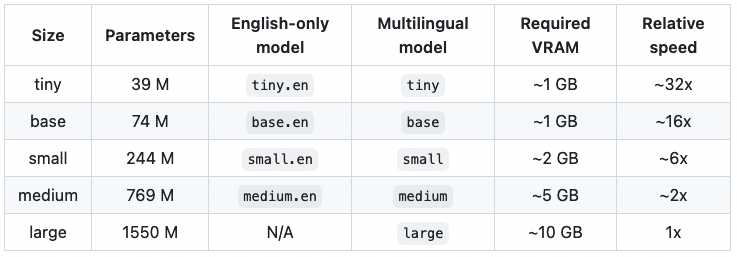

The`.en` models for English-only applications tend to perform better, especially for the `tiny.en` and `base.en` models. We observed that the difference becomes less significant for the `small.en` and `medium.en` models.

Whisper's performance varies widely depending on the language. The figure below shows a WER (Word Error Rate) breakdown by languages of the Fleurs dataset using the `large-v2` model.

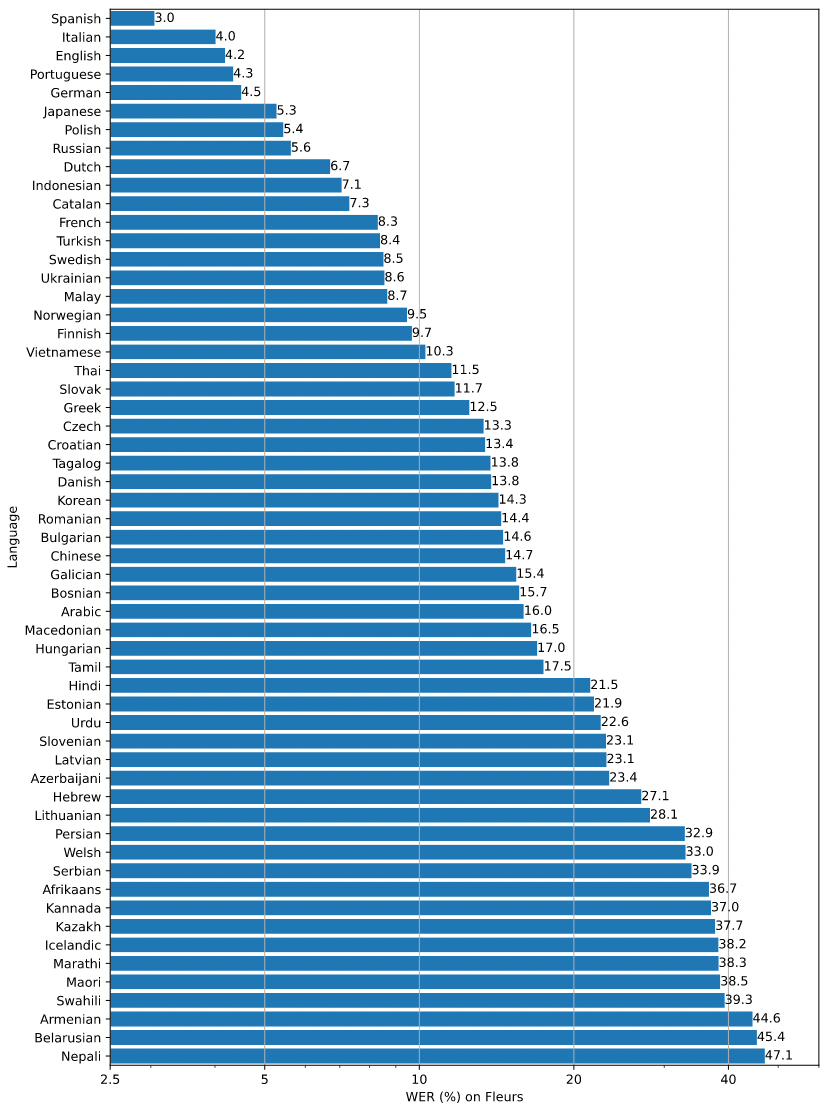

In [5]:
# instantiate a model
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 48.5MiB/s]


Model is English-only and has 71,825,408 parameters.


In [6]:
# we'll be using gradio package for interactive upload of audio files
# here we define a function that takes audio file as input
# transcribes it and returns text

def speech_to_text(audio_file):
    audio_file = audio_file if audio_file is not None else ''
    result = model.transcribe(audio_file)
    return (result["text"])

Internally, the `transcribe()` method reads the entire file and processes the audio with a sliding 30-second window, performing autoregressive sequence-to-sequence predictions on each window.

[Link to media files](https://commons.wikimedia.org/wiki/Category:Audio_files_of_females_speaking_English)

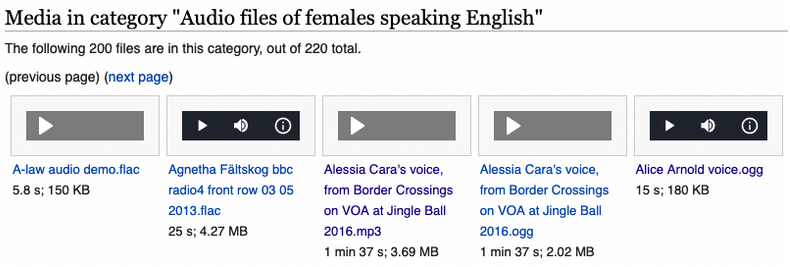

#### Article One of the United States Constitution
[WikiMedia link](https://commons.wikimedia.org/wiki/File:Article_One_of_the_United_States_Constitution_states_the_establishment_of_the_legislative_branch.ogg)

[Link to the file](https://upload.wikimedia.org/wikipedia/commons/4/42/Article_One_of_the_United_States_Constitution_states_the_establishment_of_the_legislative_branch.ogg)

17s audio file ~ 6s inference


In [7]:
# !gdown '1gH01J4odeVo-IcdL2SgWJVl1iBDUlnPU' -O constitution.mp3

In [22]:
gr.Interface(
    fn=speech_to_text,
    inputs=[gr.Audio(source="upload", type="filepath", label="Upload Audio")],
        outputs="text").launch(debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.9/dist-packages/gradio/processing_utils.py:180: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Keyboard interruption in main thread... closing server.


#### Interview Recording

In [23]:
gr.Interface(
    fn=speech_to_text,
    inputs=[gr.Audio(source="upload", type="filepath", label="Upload Audio")],
        outputs="text").launch(debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


#### Longer Audio - Podcast Episode
[Link on Apple Podcasts](https://podcasts.apple.com/us/podcast/city-limits-beware-the-doom-loop/id1346207297?i=1000604682913)

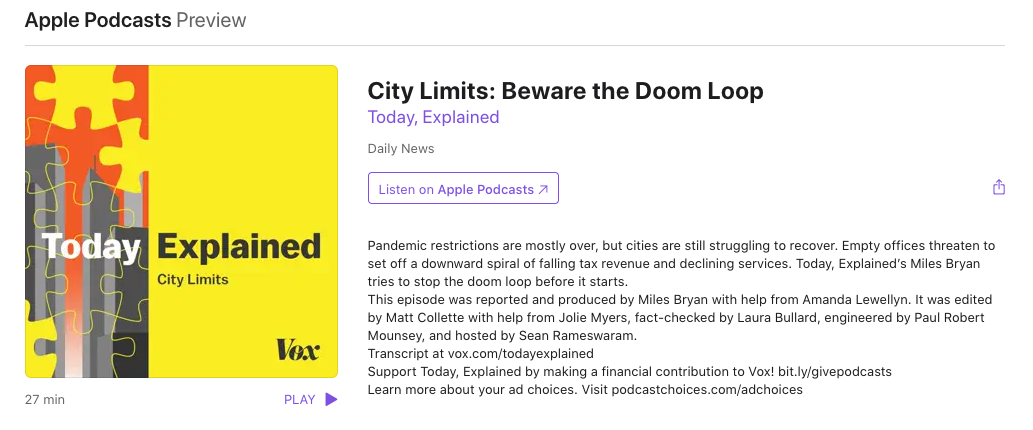

In [10]:
# pulling my file directly from GDrive
# https://drive.google.com/file/d/1wdJGYeDhmxJ0mlVCkwa9PySBxI8zHdLf/view?usp=share_link
!gdown '1wdJGYeDhmxJ0mlVCkwa9PySBxI8zHdLf' -O tex.mp3

Downloading...
From: https://drive.google.com/uc?id=1wdJGYeDhmxJ0mlVCkwa9PySBxI8zHdLf
To: /content/tex.mp3
100% 37.6M/37.6M [00:00<00:00, 71.2MB/s]


In [11]:
# result = model.transcribe('tex.mp3')
# result["text"][:500]

In [12]:
# loading multilingual model to detect language
model_ml = whisper.load_model("base")

# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("tex.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model_ml.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model_ml, mel, options)

# print the recognized text
result.text

100%|███████████████████████████████████████| 139M/139M [00:08<00:00, 18.0MiB/s]


Detected language: en


"It's been three years since the world shut down and things are back to normal. Ish. According to Bloomberg News, Manhattan workers are spending at least $12.4 billion less on meals, on shopping, on entertainment and more per year. And that's because they're spending about 30% less of their time in the office. The shift to remote work is the biggest change to urban life since cities went from being organized around factories to being organized around offices."

#### Recording from the microphone

In [13]:
# gr.Interface(
#     fn=speech_to_text,
#     inputs=[gr.Audio(source="microphone", type="filepath", label="Record Audio")],
#         outputs="text").launch(debug = True)

# Running inference on the dataset using a base Whisper model

The following will take a few minutes to transcribe all utterances in the dataset.

## Loading the LibriSpeech dataset

The following will load the test-clean split of the [LibriSpeech](https://pytorch.org/audio/stable/generated/torchaudio.datasets.LIBRISPEECH.html#torchaudio.datasets.LIBRISPEECH) corpus using torchaudio.

The LibriSpeech corpus is derived from audiobooks that are part of the LibriVox project, and contains 1000 hours of speech sampled at 16 kHz ([link to the paper](https://ieeexplore.ieee.org/document/7178964) introducing the dataset)



In [14]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True)

In [15]:
class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return (mel, text)

In [16]:
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

100%|██████████| 331M/331M [00:03<00:00, 94.6MB/s]


## Transcribing results

In [17]:
hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

  0%|          | 0/164 [00:00<?, ?it/s]

In [18]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...


## Calculating the word error rate

Now, we use our English normalizer implementation to standardize the transcription and calculate the WER.

In [19]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [20]:
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


In [21]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 4.28 %
